# Game Users' Subscription Prediction Using KNN Classification

## Introduction

<span style="font-size: 15px">

Background: </span>

A research group at UBC is hosting a Minecraft server and collecting data about the players and their play sessions to learn more about how people play video games. As part of the project they also created a newsletter that players could subscribe to for game-related information. Our group will be working with the dataset containing information about the players to answer a predictive question relating to the newsletter.

<span style="font-size: 15px">
    
Questions: </span> 

The question this project aims to answer is: <br>

**Can a user's subscription status to a game-related newsletter be predicted based on their age and playtime?**


In [81]:
# Load libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

# Load dataset
players <- read_csv(url("https://raw.githubusercontent.com/linq060119/group-project/refs/heads/main/players.csv"))
head(players)
dim(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 196   7

In this project, we will focus on the player.csv dataset, which was collected by a CS research group at UBC. The dataset contains 196 observations and 7 variables, which are:

* `experience` (character): User's game level (Beginner, Amateur, Regular, Veteran, and Pro).

* `subscribe` (logical): TRUE/FALSE, reflecting whether the user subscribes to a game-related newsletter.

* `hashedEmail` (character): unique anonymized identifier for each user.

* `played_hours` (double): Total time spent playing (0 to 223.1 hours, avg. 5.8 hours).

* `name` (character): User's name (may have duplicates).

* `gender` (character)：User's gender (Male, Female, Non-binary, Prefer not to say, Two-Spirited, Other, and Agender).

* `Age` (double): User's age (8 to 50 years, avg. 20.5 years, median 17 years, `NA` included).

The `experience` variable (character type) categorizes skill levels. Subscription status is captured by `subscribe` (logical type: TRUE/FALSE), indicating whether a user opts into a newsletter. Each player is uniquely identified by `hashedEmail` (character type), an anonymized string to protect privacy. Gameplay engagement is measured through `played_hours` (double type), ranging from 0 to 223.1 hours, with an average of 5.8 hours. Player names (`name`, character type) may include duplicates despite unique hashed emails. The `gender` variable (character type) lists seven self-reported categories. `Age` (double type) ranges from 8 to 50 years, with a median of 17 and mean of 20.5, reflecting a predominantly teenage user base.

In [82]:
players_tidy <- players |>
        filter(Age != "NA") |>
        select(subscribe, played_hours, Age) |>
        mutate(subscribe = as.factor(subscribe))
players_tidy        

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
⋮,⋮,⋮
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22


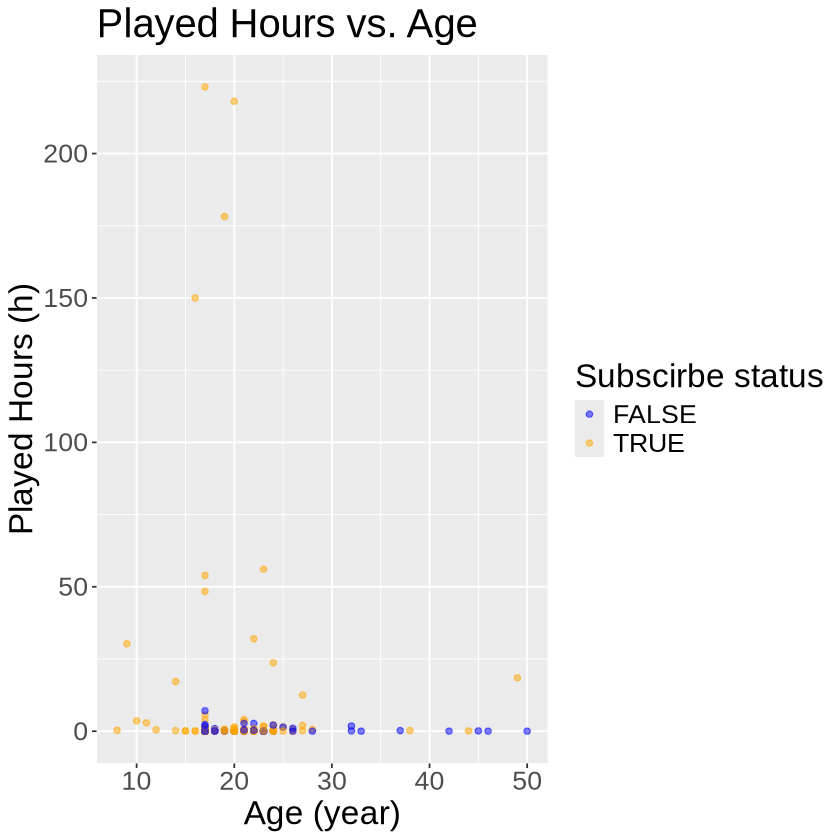

In [83]:
players_tidy_plot <- players_tidy |>
        ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(title = "Played Hours vs. Age",
        x = "Age (year)",
        y = "Played Hours (h)",
        color = "Subscirbe status")+
        scale_color_manual(values=c("blue","orange"))+
  theme(text = element_text(size = 20))
players_tidy_plot

In [84]:
summary <- players_tidy |>
    summarize(mean_age=mean(Age),
              mean_played_hours=mean(played_hours),
              range_age=max(Age)-min(Age),
              range_played_hours=max(played_hours)-min(played_hours),
              subscribe_rate=nrow(filter(players_tidy,subscribe=="TRUE"))/nrow(players_tidy))
summary


mean_age,mean_played_hours,range_age,range_played_hours,subscribe_rate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.52062,5.904639,42,223.1,0.7319588


In [113]:
set.seed(2007)
players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

head(players_train)
head(players_test)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,17
FALSE,0.0,21
FALSE,0.1,17
FALSE,0.0,23
FALSE,0.1,18
FALSE,1.4,25


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,0.7,21
TRUE,0.1,17
TRUE,0.0,17
TRUE,1.5,25
FALSE,0.0,22


K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


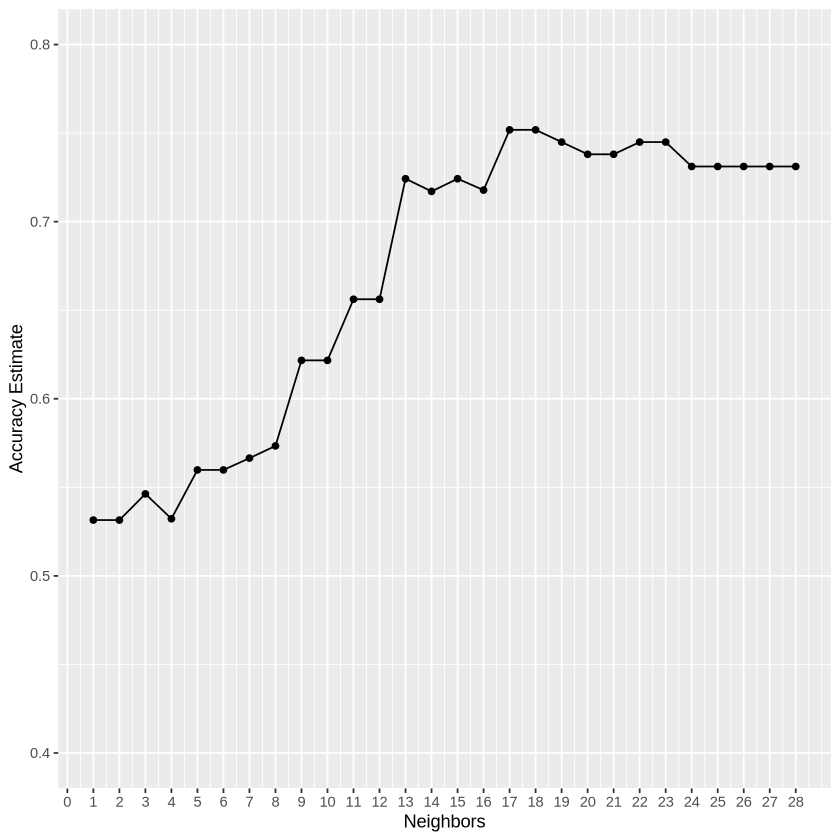

In [114]:
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

players_vfold <- vfold_cv(players_train, v = 5, strata = "subscribe")

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>          
  set_mode("classification") 
knn_tune

k_vals <- tibble(neighbors = seq(from = 1, to = 28, by = 1))
                 
knn_results <- workflow() |>
  add_recipe(players_recipe) |>          
  add_model(knn_tune) |>               
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 28, by = 1)) +  
      scale_y_continuous(limits = c(0.4, 0.8)) 
accuracy_versus_k

In [115]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      fit(data = players_train)

players_test_predictions <- predict(players_fit, new_data = players_test) |>
      bind_cols(players_test)

players_test_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,30.3,9
TRUE,TRUE,0.7,21
TRUE,TRUE,0.1,17
TRUE,TRUE,0.0,17
TRUE,TRUE,1.5,25
⋮,⋮,⋮,⋮
TRUE,FALSE,0.0,50
TRUE,FALSE,2.1,24
TRUE,TRUE,0.0,17


In [110]:
players_prediction_accuracy <- players_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)
# No Answer - remove if you provide an answer
players_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71428571
kap,binary,-0.03939394


In [111]:
players_mat <- players_test_predictions |> 
      conf_mat(truth = subscribe, estimate = .pred_class)
# No Answer - remove if you provide an answer
players_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

In [112]:
library(yardstick)
players_tibble <- tidy(players_mat)|>
    mutate(name=recode(name,
                       "cell_1_1"="TN",
                       "cell_2_1"="FP",
                       "cell_1_2"="FN",
                       "cell_2_2"="TP")) 

TN <- players_tibble |> filter(name=="TN")|>select(value)|>pull()  # True Negative
FP <- players_tibble |> filter(name=="FP")|>select(value)|>pull() # False Positive
FN <- players_tibble |> filter(name=="FN")|>select(value)|>pull() # False Negative
TP <- players_tibble |> filter(name=="TP")|>select(value)|>pull()  # True Positive
players_tibble
accuracy <- (TN + TP) / (TN + FP + FN + TP)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)

cat(sprintf("Accuracy: %.4f\nPrecision: %.4f\nRecall: %.4f",
            accuracy, precision, recall))

name,value
<chr>,<dbl>
TN,0
FP,13
FN,1
TP,35


Accuracy: 0.7143
Precision: 0.7292
Recall: 0.9722